## <div class="alert alert-danger">I. Import Dependencies</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import collections
import pickle

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D


sns.set()

## <div class="alert alert-danger">II. Preprocessing</div>

### <div class="alert alert-info">Load & Re-Shape Images</div>

In [2]:
# PATH = "C:\\Users\\mjblo\\Northwestern\\MSDS422-Practical Machine Learning\\Unit 4 - Neural Networks\\Unit 4 - CNN\\Bloch_Assignment6\\cat-and-dog"
PATH = "data"

TRAIN_PATH = PATH + "\\training_set"
TEST_PATH = PATH + "\\test_set"

CATEGORIES = ["cat","dog"]

In [3]:
def getImages( WHERE, IMG_SIZE ) :
    imgList = []
    for category in CATEGORIES :
        target_num = CATEGORIES.index( category )
        path = os.path.join( WHERE, category )
        print( "path=", path)
        for img in os.listdir( path ) :
            try:
                filename = os.path.join( path, img )
                img_array = cv2.imread( filename, cv2.IMREAD_GRAYSCALE )
#                 print( "BEFORE .... ", img_array.shape )
                new_array = cv2.resize( img_array, (IMG_SIZE, IMG_SIZE) )
#                 print( "AFTER .... ", new_array.shape )
                imgList.append( [new_array, target_num])
            except Exception as e:
                pass
    return imgList

In [4]:
# Set image size
IMG_SIZE = 90

totalData = getImages( TRAIN_PATH, IMG_SIZE  ) + getImages( TEST_PATH, IMG_SIZE  )


path= data\training_set\cat
path= data\training_set\dog
path= data\test_set\cat
path= data\test_set\dog


Total Images 10028
Category cat = 5011
Category dog = 5017


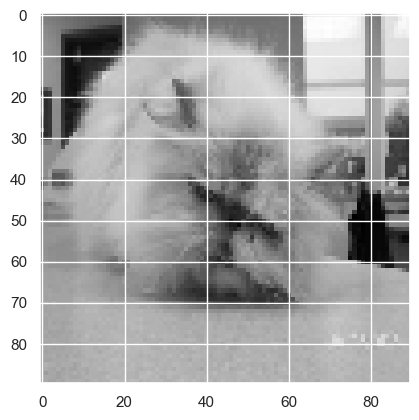

This is a cat


In [5]:
who = 0

print( "Total Images",len( totalData ))
countList = [i[1] for i in totalData ]
ctr = collections.Counter( countList )
for i in CATEGORIES :
    print("Category",i,"=",ctr[ CATEGORIES.index(i)] )

random.shuffle( totalData )
theRecord = totalData[who]
theValue = theRecord[1]
theImg = theRecord[0]
plt.imshow( theImg, cmap="gray" )
plt.show()

print("This is a",CATEGORIES[ theValue ] )

In [6]:
X = []
Y = []

for [features,label] in totalData :
    X.append( features )
    Y.append( label )

X = np.array( X ).reshape( -1, IMG_SIZE, IMG_SIZE, 1)
print( X.shape )

Y = np.array( Y ).reshape( -1, )
print( Y.shape )

(10028, 90, 90, 1)
(10028,)


### <div class="alert alert-info">Pickle & Save Transformed Images</div>

In [7]:
pickle_out = open("X.pickle","wb")
pickle.dump( X, pickle_out )
pickle_out.close()

pickle_out = open("Y.pickle","wb")
pickle.dump( Y, pickle_out )
pickle_out.close()

### <div class="alert alert-info">Load Re-Shaped Images</div>

In [8]:
pickle_in = open("X.pickle","rb")
XRAW = pickle.load( pickle_in )
pickle_in.close()

pickle_in = open("Y.pickle","rb")
Y = pickle.load( pickle_in )
pickle_in.close()

### <div class="alert alert-info">Normalize Data</div>

In [9]:
# Normalize the data
X = XRAW / 255.0

In [10]:
print( Y.shape )

Z = X[0]
print( X.shape )
print( Z.shape )

(10028,)
(10028, 90, 90, 1)
(90, 90, 1)


### <div class="alert alert-info">Split Test-Train Datasets</div>

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)

### <div class="alert alert-info">Define Model Accuracy Metrics</div>

In [12]:
def get_TF_ProbAccuracyScores( NAME, MODEL, X, Y ) :
    probs = MODEL.predict( X )
    pred_list = []
    for p in probs :
        pred_list.append( np.argmax( p ) )
    pred = np.array( pred_list )
    acc_score = metrics.accuracy_score(Y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( Y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]


def print_ROC_Curve( TITLE, LIST ) :
    pass
    fig = plt.figure(figsize=(6,4))
    plt.title( TITLE )
    for theResults in LIST :
        NAME = theResults[0]
        fpr = theResults[2]
        tpr = theResults[3]
        auc = theResults[4]
        theLabel = "AUC " + NAME + ' %0.2f' % auc
        plt.plot(fpr, tpr, label = theLabel )
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def print_Accuracy( TITLE, LIST ) :
    print( TITLE )
    print( "======" )
    for theResults in LIST :
        NAME = theResults[0]
        ACC = theResults[1]
        print( NAME, " = ", ACC )
    print( "------\n\n" )

    
def confusion_Matrix( NAME, MODEL, X, Y ) :
    probs = MODEL.predict( X )
    probs = list( probs[0] )
    print( probs )
    maxValue = max( probs )
    print(maxValue)
    

## <div class="alert alert-danger">III. Convolutional Neural Network</div>

### <div class="alert alert-info">Define Model Specifications</div>

In [13]:
theShapeSize = Z.shape
theActivation = tf.keras.activations.relu
theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()
theOptimizer = tf.keras.optimizers.Adam()

# Fill in the values you believe will give the best results
theEpochs = 20
theUnits = 32
theSplit = 0.1
theBatchSize = 32

In [14]:
LAYER_CONV2D_01 = tf.keras.layers.Conv2D( theUnits, (3,3), activation=theActivation, input_shape=theShapeSize  )
LAYER_POOL_01 = tf.keras.layers.MaxPooling2D( pool_size=(2,2) )

LAYER_CONV2D_02 = tf.keras.layers.Conv2D( 2*theUnits, (3,3), activation=theActivation, input_shape=theShapeSize  )
LAYER_POOL_02 = tf.keras.layers.MaxPooling2D( pool_size=(2,2) )

LAYER_CONV2D_03 = tf.keras.layers.Conv2D( 4*theUnits, (3,3), activation=theActivation, input_shape=theShapeSize  )
LAYER_POOL_03 = tf.keras.layers.MaxPooling2D( pool_size=(2,2) )

LAYER_CONV2D_04 = tf.keras.layers.Conv2D( 8*theUnits, (3,3), activation=theActivation, input_shape=theShapeSize  )
LAYER_POOL_04 = tf.keras.layers.MaxPooling2D( pool_size=(2,2) )

LAYER_DROP = tf.keras.layers.Dropout( 0.2 )

LAYER_FLATTEN = tf.keras.layers.Flatten()

LAYER_DENSE_01 = tf.keras.layers.Dense( units=8*theUnits, activation=theActivation )

LAYER_OUT = tf.keras.layers.Dense(2, activation=tf.nn.softmax )

### <div class="alert alert-info">Model Training</div>

In [15]:
model = tf.keras.models.Sequential()

model.add( LAYER_CONV2D_01 )
model.add( LAYER_POOL_01 )
model.add( LAYER_DROP )
model.add( LAYER_CONV2D_02 )
model.add( LAYER_POOL_02 )
model.add( LAYER_DROP )
model.add( LAYER_CONV2D_03 )
model.add( LAYER_POOL_03 )
model.add( LAYER_DROP )
model.add( LAYER_CONV2D_04 )
model.add( LAYER_POOL_04 )
model.add( LAYER_DROP )

model.add( LAYER_FLATTEN )
model.add( LAYER_DENSE_01 )
model.add( LAYER_OUT )

model.compile( optimizer = theOptimizer, loss=theLossMetric, metrics=['accuracy'] )
model.fit( X_train, Y_train, epochs=theEpochs, batch_size=theBatchSize, validation_split=theSplit )

Epoch 1/20
226/226 [==============================] - 59s 253ms/step - loss: 0.6933 - accuracy: 0.5089 - val_loss: 0.6935 - val_accuracy: 0.4894
Epoch 2/20
226/226 [==============================] - 57s 252ms/step - loss: 0.6908 - accuracy: 0.5160 - val_loss: 0.6916 - val_accuracy: 0.5405
Epoch 3/20
226/226 [==============================] - 56s 249ms/step - loss: 0.6852 - accuracy: 0.5531 - val_loss: 0.6943 - val_accuracy: 0.4894
Epoch 4/20
226/226 [==============================] - 56s 250ms/step - loss: 0.6838 - accuracy: 0.5578 - val_loss: 0.6665 - val_accuracy: 0.6139
Epoch 5/20
226/226 [==============================] - 58s 258ms/step - loss: 0.6537 - accuracy: 0.6177 - val_loss: 0.6134 - val_accuracy: 0.6538
Epoch 6/20
226/226 [==============================] - 62s 273ms/step - loss: 0.6092 - accuracy: 0.6660 - val_loss: 0.5983 - val_accuracy: 0.6712
Epoch 7/20
226/226 [==============================] - 58s 256ms/step - loss: 0.5596 - accuracy: 0.7141 - val_loss: 0.5368 - val_ac

### <div class="alert alert-info">Model Testing</div>

63/63 [==============================] - 3s 54ms/step


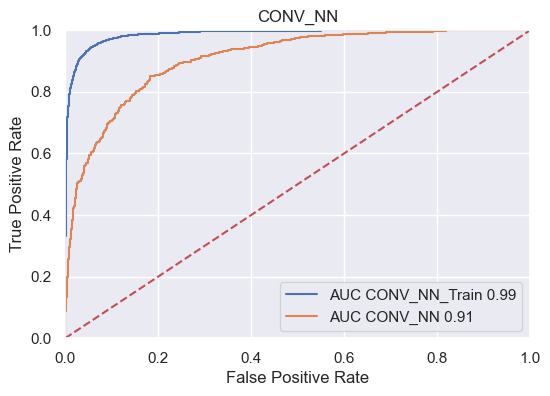

CONV_NN CLASSIFICATION ACCURACY
CONV_NN_Train  =  0.9289454001495886
CONV_NN  =  0.8110667996011964
------




In [16]:
WHO = "CONV_NN"

TRAIN_RES = get_TF_ProbAccuracyScores( WHO + "_Train", model, X_train, Y_train )
TEST_RES = get_TF_ProbAccuracyScores( WHO, model, X_test, Y_test )

print_ROC_Curve( WHO, [ TRAIN_RES, TEST_RES ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_RES, TEST_RES ] )

## <div class="alert alert-danger">IV. Scoring the Model on New Images</div>

### <div class="alert alert-info">Testing New Images</div>

In [17]:
CATEGORIES = ["CAT","DOG"]
IMG_SIZE = 90

# PATH = "C:\\Users\\mjblo\\Northwestern\\MSDS422-Practical Machine Learning\\Unit 4 - Neural Networks\\Unit 4 - CNN\\Bloch_Assignment6\\test_images"
PATH = "test_images"

files = [
    "DOG_001.jpg", 
    "DOG_002.jpg", 
    "DOG_003.jpg", 
    "DOG_004.jpg", 
    "DOG_005.jpg", 
    "CAT_001.jpg", 
    "CAT_002.jpg", 
    "CAT_003.jpg", 
    "CAT_004.jpg",
    "CAT_005.jpg"
    ]

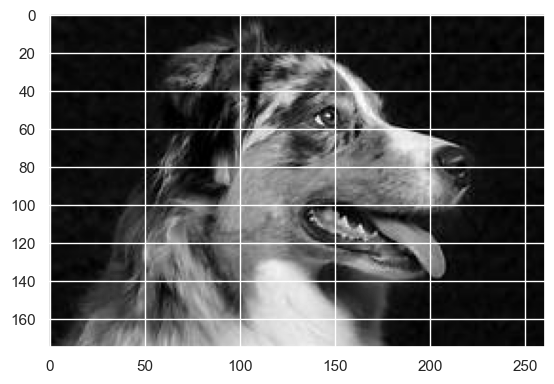

1/1 [==============================] - 0s 35ms/step
Probability of Cat:  1.48516 %
Probability of Dog:  98.51484 %
Class:  DOG




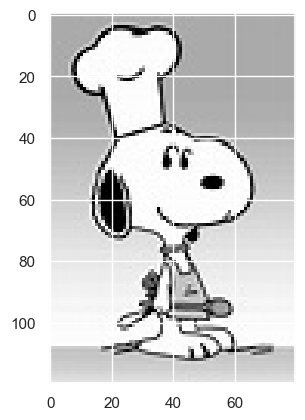

1/1 [==============================] - 0s 47ms/step
Probability of Cat:  27.37538 %
Probability of Dog:  72.62462 %
Class:  DOG




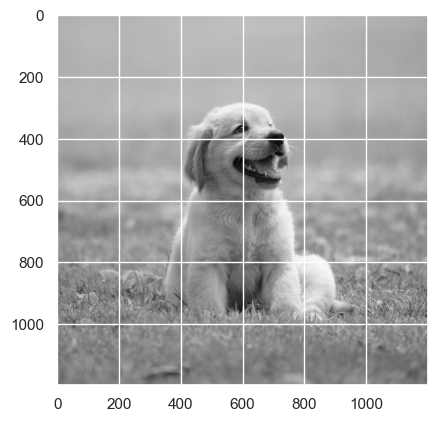

1/1 [==============================] - 0s 17ms/step
Probability of Cat:  4.588 %
Probability of Dog:  95.412 %
Class:  DOG




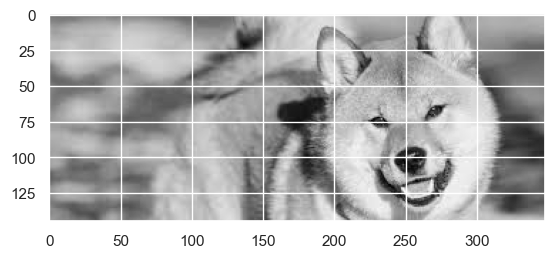

1/1 [==============================] - 0s 33ms/step
Probability of Cat:  64.40451 %
Probability of Dog:  35.5955 %
Class:  CAT




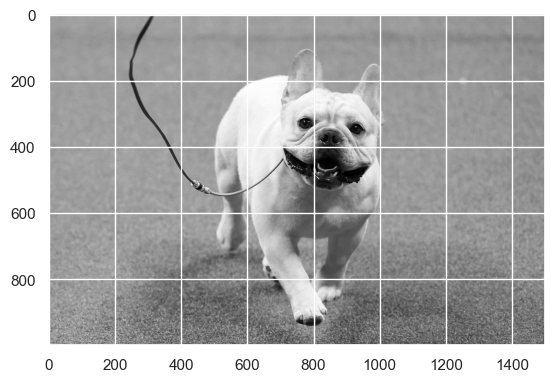

1/1 [==============================] - 0s 53ms/step
Probability of Cat:  8.96878 %
Probability of Dog:  91.03122 %
Class:  DOG




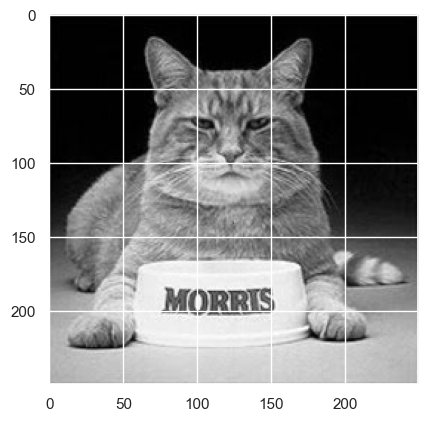

1/1 [==============================] - 0s 39ms/step
Probability of Cat:  99.81035 %
Probability of Dog:  0.18965 %
Class:  CAT




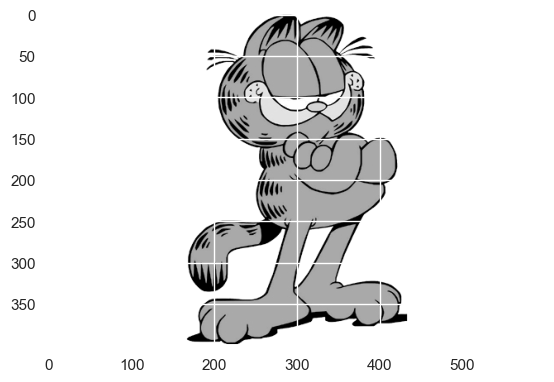

1/1 [==============================] - 0s 38ms/step
Probability of Cat:  23.04 %
Probability of Dog:  76.96 %
Class:  DOG




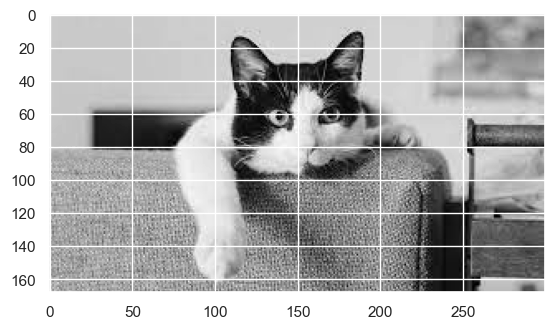

1/1 [==============================] - 0s 25ms/step
Probability of Cat:  60.9055 %
Probability of Dog:  39.0945 %
Class:  CAT




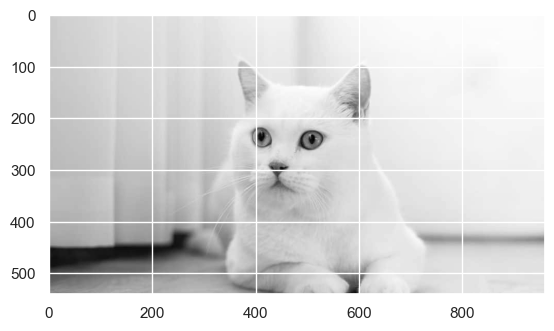

1/1 [==============================] - 0s 31ms/step
Probability of Cat:  90.2167 %
Probability of Dog:  9.78331 %
Class:  CAT




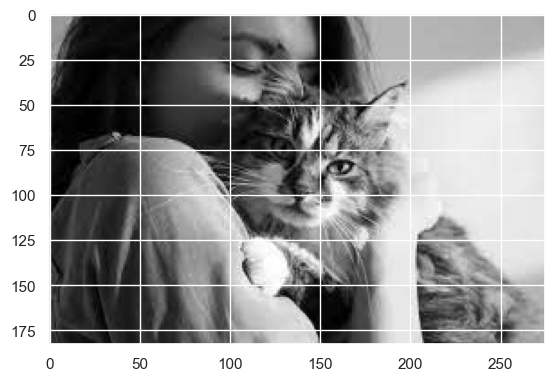

1/1 [==============================] - 0s 18ms/step
Probability of Cat:  78.85631 %
Probability of Dog:  21.14369 %
Class:  CAT




In [18]:
for img in files:
    
    FILENAME = os.path.join( PATH, img )
    IMG_RAW = cv2.imread( FILENAME, cv2.IMREAD_GRAYSCALE )
    IMG = cv2.resize( IMG_RAW, (IMG_SIZE, IMG_SIZE) )

    X_RAW = np.array( IMG ).reshape( -1, IMG_SIZE, IMG_SIZE, 1)
    
    plt.imshow( IMG_RAW, cmap="gray" )
    plt.show()

    X = X_RAW/255.0
    
    Y = model.predict(X)
    Y = list( Y[0] )
    print("Probability of Cat: ", round(Y[0]*100, 5),"%")
    print("Probability of Dog: ", round(Y[1]*100, 5),"%")

    maxValue = max( Y )
    theIndex = Y.index( maxValue )

    print("Class: ", CATEGORIES[ theIndex ])
    print("\n")

## <div class="alert alert-danger">V. Save the Model</div>

In [19]:
theTensorFlowSaveFile = "catdog.model.h5"
tf.keras.models.save_model( model, theTensorFlowSaveFile)